In [8]:
using MatrixProductBP, MatrixProductBP.Models
using Statistics, Base.Threads, Plots, Graphs, IndexedGraphs, Random
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2
import Measurements: value;

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [10]:
include("../../telegram/notifications.jl");

In [43]:
c = 3      # mean connectivity of Erdos-Renyi graph

J = 1/c    # coupling
β = 1/0.5  # inverse temperature
h = 0.2;    # external field 

In [146]:
using Distributions
cb = CB_Pop(;f = x->mean(tanh, x))
m_eq = equilibrium_magnetization(ErdosRenyi(c); pJ=Dirac(J), ph=MixtureModel(Dirac, [h,-h]), β,
    popsize=10^6, tol=1e-12, maxiter=50, nsamples=10^4, cb, rng=MersenneTwister(1), P=ones(10^6))

Running PopDyn: iter 50 	 Time: 0:04:11
  it:  50/50
  ε:   0.000456908675/1.0e-12┌ Warning: Population dynamics did not converge. Error 0.0004569086751800011
└ @ MatrixProductBP.Models /home/crotti/MatrixProductBP/src/Models/glauber/equilibrium.jl:105


0.7131 ± 0.0035

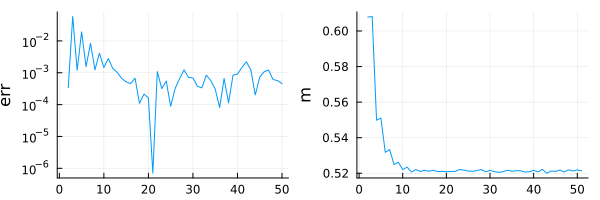

In [147]:
plot( plot(cb.Δs, label="", ylabel="err", yaxis=:log10), plot(cb.m, label="", ylabel="m"), size=(600,200))

In [142]:
using Distributions
cb = CB_Pop(;f = x->mean(tanh, x))
m_eq = equilibrium_magnetization(ErdosRenyi(c); pJ=Dirac(J), ph=MixtureModel(Dirac, [h,-h]), β,
    popsize=10^6, tol=1e-12, maxiter=50, nsamples=10^4, cb)

Running PopDyn: iter 50 	 Time: 0:04:01
  it:  50/50
  ε:   0.001238340278/1.0e-12┌ Warning: Population dynamics did not converge. Error 0.0012383402779073682
└ @ MatrixProductBP.Models /home/crotti/MatrixProductBP/src/Models/glauber/equilibrium.jl:105


0.7148 ± 0.0035

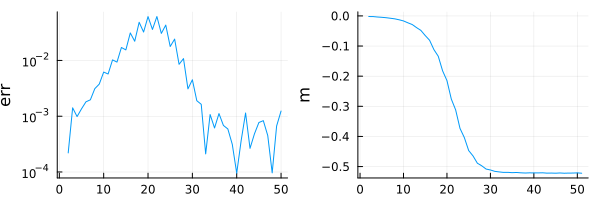

In [143]:
plot( plot(cb.Δs, label="", ylabel="err", yaxis=:log10), plot(cb.m, label="", ylabel="m"), size=(600,200))

In [86]:
m⁰ = 0.95  # magnetization at time zero
T = 30
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
N = 10^3
g = erdos_renyi(N, c/N)
spin(x) = 3-2x
rng = MersenneTwister(333)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=h*rand(rng, (-1,1), N), β)
bp = mpbp(Glauber(ising, T); ϕ=fill(ϕᵢ, N))
sms = SoftMarginSampler(bp);

In [90]:
sample!(sms, 10^2);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:00:02


In [91]:
m_mc = [vec(spin.(mean(X, dims=1))) for X in sms.X];

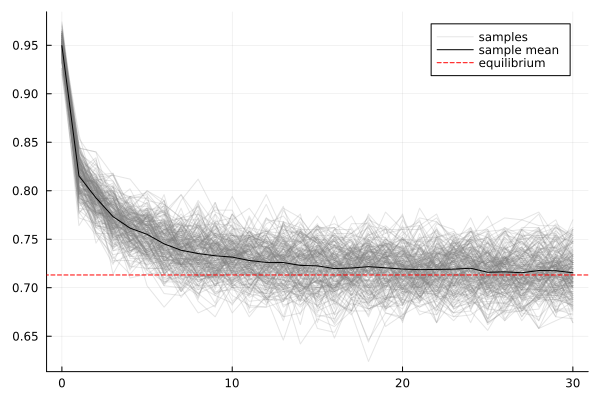

In [148]:
pl = plot(0:T, m_mc, label=permutedims(["samples"; fill("", length(m_mc)-1)]), c=:gray, la=0.2)
plot!(pl, 0:T, mean(m_mc), c=:black, label="sample mean")
hline!([value(m_eq)], label="equilibrium", c=:red, ls=:dash)